
# Predictive Modelling of Revenues of Modern American Movies 
#### by Stephen Gou
#### Oct 28, 2018
#### Student Number: 1000382908

## Introduction

A movie's box office is the most common metric to gauge its success. A good prediction of the revenue of a movie can guide production companies for building successful movies, and inform investors to pick out the most profitable movies. This project builds a model that predicts a movie's total revenue, given certain traits and facts about the movie. Only movies produced in the United States from 1990 to 2016 are considered, because the entertainment industry and economy changes over time. Movies produced after 2016 are not considered, because have not reached their full total revenue potential. Only movies produced in the U.S are considered, because the market characteristics vary over countries and the modelling of this aspect is beyond the scope of this project.
     
To build an effective predictive model and gain insight, the project first explores and analyzes the major factors that affect a movie's revenue. And then, a model that best suits the case will be selected and trained. Its performance will be analyzed and compared to an alternative model. Last but not least, the model's limitations and potential improvements will be discussed.
    
## Data Collection
This project makes use of several sources to collect data for analysis and training. Various types of data are collected that includes movie's revenue, budget, meta-data, cast, crews, rankings of actors and actresses and so on. The detail of all the datasets used is listed below.

1) TMDB 5000 Movies dataset. This is the main dataset which provides budget, revenue, runtime, genre, release-date and production country data. Source: https://www.kaggle.com/tmdb/tmdb-movie-metadata

2) New York Times Review dataset. This dataset includes data like whether a movie was picked by NYT critics, and review summaries. Source: NYT API

3) TMDB 5000 Crew dataset. This dataset has detailed cast and crew information, ranging from actor to writer, for each movie. Source: https://www.kaggle.com/tmdb/tmdb-movie-metadata

4) Top Actors/Actresses Rank. This the list of a Top 1000 Actors/Actresses Ranking released by IMDb. Source: IMDb

5) Top directors Rank. This the list of a Directors Ranking released by IMDb. Source: IMDb

6) Annual CPI. This dataset lists the annual average CPI for U.S. Source: UsInflationCalculator.com

### Cleaning
Movies produced before 1990 and after 2016 are discarded. Movies produced outside of U.S are discarded. Some movies have zero revenue in the dataset, which might be a result of missing data or unreleased movie. These movies are removed.

## Feature Selection and Mapping
There are a large amount of factors that might affect a movie's revenues ranging from movies' meta-data, to unemployment rate of the release year. Features that will be analyzed and incorporated into the predictive model are selected based on availability, informativeness, unambiguity, and interpretability. According to this criteria, the following features are selected: budget, runtime, critics-pick, genres, MPAA-rating, cast, and director. The following procedures and transformations of data are done to make data representable for modelling and to increase accuracy.

1) The cast of a movie is represented by a popularity score, which is calculated by the following rule. A percentile rank score for each cast is calculated according to the actors rank dataset. Then use 1 - percentage rank as the popularity score for a cast. So 1 is the highest one can get and 0 is the lowest (0 if cast not in the ranking). Then the cast popularity for the movie is calculated as following:
$$ Cast\ Popularity\ Score = \sum_{i}^{N} \gamma ^ i (1 - Percentile Rank (Cast\ i)) $$ where gamma is a decay factor and N is the number of casts.

2) The director is represented by a popularity score, which is calculated by the following rule. A percentile rank score is calculated according to the directors rank dataset. Then use 1 - percentage rank as the popularity score. So 1 is the highest one can get and 0 is the lowest (0 if director not in the ranking).

3) The revenue and budget are adjusted for inflation according to the rule: $$ adjusted = \frac{CPI(2017)}{CPI(release  \,year)} * unadjusted. $$ CPI are from the Annual CPI data.

4) Genres are converted by one-hot encoding. Note that a movie can have multiple genres associated with it.

5) MPAA ratings are converted by one-hot encoding.

6) Runtime represented by a number and unchanged.

7) Critics pick is represented by 1 or 0 (1 repesents being picked)


## Exploratory Data Analysis
Some observations can be made from the statistics of our wrangled dataset. There are 2,033 movies in our final dataset. 17% of the movies are picked by the critics. Average runtime of a movie is 108 minutes while the lengthiest runs more than 4 hours, the shortest runs 46 mintues.

#### Distributions of Data
![revenue and budget](Images/revenue_budget_boxplot.png)
Revenues and budgets of movies are concentrated in low values, \\$ 78m and \\$ 37m respectively. There are large number of outliers in both cases. However, revenue has very long-tail towards higher values and outliers with more extreme values.

![genres](Images/genres_pie_chart.png)
![rating](Images/mpaa_ratings_pie_chart.png)

There are quite diverse and evenly distributed number of genres in the data. And majority of movies are at least PG-13.

#### Correlations Between Features
A heatmap of correlation between features is plotted to spot features that have strong relationships with each other, so that redundant features can be discarded to reduce multicollinearity.

<img src=Images/corr_heatmap2.png width="800">

Genres and mpaa-rating tend to have strong correlations. From the plot, it's clear that movies that have "family" as a genre is also very likely to have "animation" as a genre as well. Family and animation movies also usually have PG or G rating. 

The quality of the cast appear to be uncorrelated with most of the genres of movies except for horror, where quality of cast drops significantly.

Intuitively, the runtime of a movie has correlations with its genres, which is confirmed by the heatmap. The runtime also correlates with budget and quality of director and cast. 

Another interesting observation is that New York Time's critics' picks appear to be uncorrelated with most of the features of a movie, meaning that they are not favoring a particular subsets of movies over the others. Action and thriller movies are marginally less likely to be picked, but that could just be a result of noise.

From these observations, runtime and mpaa-rating of a movie could be potentially discarded, because they usually depend on other features of the movie.



## Analysis and Modelling
Since the goal is to predict revenue, a continuous value over a wide range, regression models are considered. More specifically, OLS regression, Ridge/Lasso regression and Random Forest regression are the candidate models. The models' performance are evaluated based on the R-Squared statistic and the residual plot.

An OLS regression model that simply includes all the features without adding higher order terms and interactions is fitted and its result is used as a baseline. Model is trained on training set, which is 70% of the dataset.

It obtained a __R-Squared score of 0.492__ on the test set and the residual plot as below:
![](Images/baseline_residual1.png)

### Feature Analysis and Engineering
The goal is to improve the predictive power of models through finding and creating better features. 1) find features that have significant influence on our dependable variable, revenue 2) discard features that heavily correlate with other features to reduce multi-collinearity 3) brainstorm and discover interactions between features 4) consider cofounders and higher order terms of the features. OLS regression and Logistic regression are used to perform the analysis.

* Like suggested in EDA, mpaa-rating is discarded because it depends on other features.

* Intuitively, revenues are more than linearly related with star and director power and budget. Thus,quadratic terms of cast score, director score, budget score are added to the model, and it improves the fitting of the model. Exponential terms are experimented with too, and it gives similar result to quadratic terms.

* Intuitively, the cast's influence on the revenue might depend on the genres of the movie as well. Interaction between cast and each genres are added to the model, but most of them have very large p-values except for animation and adventure, which have significant p-values.


### Predictive Modelling




pre release model, post release model
regression
regression tree
KNN
## Results
we found that xxxx are major factors, yyy not so much.
thus we built a model with ... with zzz model.
Multicollinearity (dummy varaible trap)
## Conclusion
### Future Work
Actors and directors representation
Incorporate economy/meta data, e.g GDP growth rate of the year of release, unemployment rate.

## Python Code

In [27]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; 
from pandas.io.json import json_normalize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Cleaning and Feature Mapping

In [2]:
github_raw_root = 'Datasets/' #'https://raw.githubusercontent.com/gouzhen1/Moives-Data-Analysis/master/Datasets/'

#NY Reviews Dataset
ny_df = pd.read_csv(github_raw_root + 'NY_movie_reviews.csv')
ny_df.rename(columns={'display_title':'title'},inplace=True)
ny_df = ny_df[['title','mpaa_rating','critics_pick']]

#Wrangle actors and director
#TMDB Credits Dataset (for cast and director)
tmdb_credits_df = pd.read_csv(github_raw_root + 'tmdb_5000_credits.csv')
actors_rank = pd.read_csv(github_raw_root + 'Top_actors_rank.csv')['Name'].tolist()
directors_rank = pd.read_csv(github_raw_root +'All_time_director_rank.csv')['Name'].tolist()
total_actors = len(actors_rank)
total_directors = len(directors_rank)
        
def transform_cast(df):
    cast_json = df['cast']
    parsed_cast = json.loads(cast_json)
    score = 0.
    count = 0 
    for cast in parsed_cast:
        actor = cast['name']
        if actor in actors_rank:
            #discounted for later casts
            score += (0.8 ** count) * (1. - (actors_rank.index(actor)/total_actors))
        count += 1
    return score
tmdb_credits_df['cast_score'] = tmdb_credits_df.apply(transform_cast, axis = 1)

def transform_crew(df):
    crew_json = df['crew']
    parsed_crew = json.loads(crew_json)
    score = 0.
    for crew in parsed_crew:
        if crew['department'] == 'Directing' and crew['job'] == 'Director':
            director = crew['name']
            if director in directors_rank:
                score += (1. - (directors_rank.index(director)/total_directors))
            break
    return score

tmdb_credits_df['director_score'] = tmdb_credits_df.apply(transform_crew, axis = 1)
tmdb_credits_df = tmdb_credits_df[['title','cast_score','director_score']]

#TMDB Main Dataset
main_df = pd.read_csv(github_raw_root + 'tmdb_5000_movies.csv')
main_df['release_date'] = pd.to_datetime(main_df['release_date'])
main_df.drop(main_df[main_df['release_date'].dt.year < 1990].index, inplace=True)
main_df.drop(main_df[main_df['release_date'].dt.year > 2016].index, inplace=True)
main_df = main_df[main_df['revenue'] > 0]
main_df = main_df.merge(ny_df,how='left')
    
#process and filter countries
def process_country(df):
    country_json = df['production_countries']
    parsed_country = json.loads(country_json)
    if len(parsed_country) > 0:
        return parsed_country[0]['name']
    else:
        return None
main_df['production_countries'] = main_df.apply(process_country, axis = 1)
main_df = main_df[main_df['production_countries'] =='United States of America']
main_df.drop(columns='production_countries',inplace=True)

#wrangle genre
genre_dict = {}
def transform_genre(df):
    genre_json = df['genres']
    parsed_genre = json.loads(genre_json)
    result = []
    for genre in parsed_genre:
        genre_name = genre['name'].replace(' ','_')
        result.append(genre_name)
        if genre_name not in genre_dict:
            genre_dict[genre_name] = 1
        else:
            genre_dict[genre_name] += 1
    
    return result
main_df['genres'] = main_df.apply(transform_genre, axis = 1)
#drop very low rare genres
del genre_dict['Foreign']
for genre in genre_dict:
    main_df['is_' + genre] = main_df['genres'].transform(lambda x: int(genre in x))
main_df.drop(columns=['genres'],inplace=True)

#map mpaa rating
rating_df = pd.get_dummies(main_df['mpaa_rating'],prefix='rating')
main_df = main_df.merge(rating_df,left_index=True,right_index=True)
main_df.drop(columns=['mpaa_rating','rating_Not Rated'],inplace=True) #drop one category to avoid multicollinearity

#adjust revenue and budget for inflation
cpi_df = pd.read_csv(github_raw_root + 'Annual_CPI.csv')
cpi_df = cpi_df.set_index('DATE')
cpi_dict = cpi_df.to_dict()['CPIAUCSL']
def get_cpi_adjusted_revenue(df):
    year = df['release_date'].year
    revenue = df['revenue']
    return cpi_dict['2017-01-01']/cpi_dict['{}-01-01'.format(year)] * revenue

def get_cpi_adjusted_budget(df):
    year = df['release_date'].year
    budeget = df['budget']
    return cpi_dict['2017-01-01']/cpi_dict['{}-01-01'.format(year)] * budeget

main_df['revenue'] = main_df.apply(get_cpi_adjusted_revenue,axis=1)
main_df['budget'] = main_df.apply(get_cpi_adjusted_budget,axis=1)
main_df['revenue'] = main_df['revenue'] * 0.000001
main_df['budget'] = main_df['budget'] * 0.000001
main_df = main_df.drop(columns = ['release_date','original_language','popularity','homepage','overview','spoken_languages','tagline','original_title','vote_average','vote_count','id','status','production_companies','keywords'])


In [3]:

print('wrangled dataset: ' + str(main_df.shape))
main_df = main_df.merge(tmdb_credits_df,how='left')
main_df.columns = map(str.lower, main_df.columns)
main_df.rename(columns={'rating_pg-13':'rating_pg_thirteen','rating_nc-17':'rating_nc_seventeen'},inplace=True)
main_df['critics_pick'].fillna(0,inplace=True)
main_df.to_csv('wrangled_dataset.csv')
main_df.rename(columns={'rating_not rated':'rating_not_rated'},inplace=True)
main_df.head()


wrangled dataset: (2033, 28)


,budget,revenue,runtime,title,critics_pick,is_action,is_adventure,is_fantasy,is_science_fiction,is_crime,...,is_war,is_music,is_documentary,rating_g,rating_nc_seventeen,rating_pg,rating_pg_thirteen,rating_r,cast_score,director_score
0,270.771526,3185.238655,162.0,Avatar,1.0,1,1,1,1,0,...,0,0,0,0,0,0,1,0,1.141077,0.836364
1,354.684562,1136.172881,169.0,Pirates of the Caribbean: At World's End,0.0,1,1,1,0,0,...,0,0,0,0,0,0,1,0,1.943331,0.400000
2,266.936095,1158.437625,165.0,The Dark Knight Rises,1.0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,3.147587,0.709091
3,277.613539,303.387927,132.0,John Carter,0.0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,1.339893,0.000000
4,305.028724,1053.261376,139.0,Spider-Man 3,0.0,1,1,1,0,0,...,0,0,0,0,0,0,1,0,1.381308,0.490909


## EDA

In [26]:
main_df.describe()

,budget,revenue,runtime,critics_pick,is_action,is_adventure,is_fantasy,is_science_fiction,is_crime,is_drama,...,is_war,is_music,is_documentary,rating_g,rating_nc_seventeen,rating_pg,rating_pg_thirteen,rating_r,cast_score,director_score
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,...,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000
mean,54.405731,162.734096,108.094840,0.138084,0.258968,0.186241,0.099754,0.120885,0.158722,0.441769,...,0.019165,0.032924,0.014742,0.019656,0.000983,0.108600,0.296806,0.320393,1.083142,0.072986
std,53.526064,238.730589,18.560045,0.345072,0.438176,0.389397,0.299746,0.326073,0.365507,0.496720,...,0.137137,0.178481,0.120548,0.138849,0.031342,0.311213,0.456963,0.466742,0.770948,0.209531
min,0.000000,0.000015,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.446526,25.164840,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.407677,0.000000
50%,37.632211,78.458092,105.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.056600,0.000000
75%,77.706677,198.331272,118.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.636858,0.000000
max,414.154688,3185.238655,254.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.307431,1.000000


In [ ]:
sum_df = main_df.apply(np.sum,axis = 0)
#genres pie chart
plt.pie(sum_df[5:-7],labels = sum_df.index[5:-7])
plt.show()

In [ ]:
#mpaa ratings pie chart
plt.pie(sum_df[-7:-2],labels = sum_df.index[-7:-2])
plt.show()

In [ ]:
sns.boxplot(data = main_df[['revenue','budget']])
plt.show()

In [ ]:
sns.boxplot(data = main_df[['budget']])
plt.show()

In [ ]:
sns.set(style="ticks", color_codes=True)
#plt.scatter(main_df['budget'],main_df['revenue'])
sns.pairplot(main_df[['budget','revenue','runtime','director_score','cast_score','critics_pick']],kind='reg',diag_kind='kde')

In [ ]:
corr = main_df.corr()
plt.figure(figsize = (28,28))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


## Feature Analysis

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     87.39
Date:                Mon, 29 Oct 2018   Prob (F-statistic):          5.65e-282
Time:                        16:49:56   Log-Likelihood:                -13324.
No. Observations:                2035   AIC:                         2.670e+04
Df Residuals:                    2011   BIC:                         2.683e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -174.6824     30

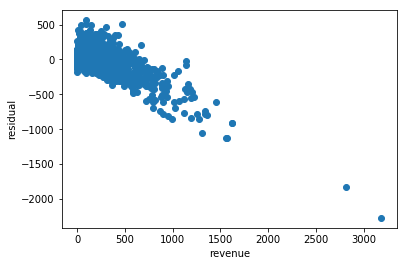

In [118]:
formula = '''revenue ~ 
                    budget + runtime + critics_pick
                    + is_action + is_adventure+is_fantasy+is_science_fiction + is_crime + is_drama + is_thriller + is_animation + is_family + is_western + is_comedy + is_romance + is_horror + is_mystery + is_history + is_war + is_music + is_documentary
                    + cast_score + director_score
                    '''
results = smf.ols(formula, data=main_df).fit()
print(results.summary())
print(results.summary())
plt.scatter(main_df['revenue'], results.fittedvalues - main_df['revenue'])
plt.xlabel('revenue')
plt.ylabel('residual')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     26.87
Date:                Mon, 29 Oct 2018   Prob (F-statistic):          1.84e-297
Time:                        16:52:36   Log-Likelihood:                -13131.
No. Observations:                2035   AIC:                         2.647e+04
Df Residuals:                    1932   BIC:                         2.705e+04
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

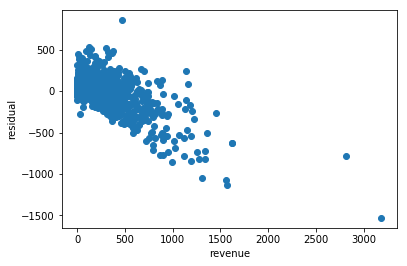

In [120]:
formula = '''revenue ~ 
                    budget + runtime + critics_pick
                    + is_action + is_adventure+is_fantasy+is_science_fiction + is_crime + is_drama + is_thriller + is_animation + is_family + is_western + is_comedy + is_romance + is_horror + is_mystery + is_history + is_war + is_music + is_documentary                
                    + cast_score + director_score
                    
                    + is_action * cast_score
                    + is_science_fiction * cast_score
                    + is_crime * cast_score
                    + is_drama * cast_score
                    + is_thriller * cast_score
                    + is_western * cast_score
                    + is_comedy * cast_score
                    + is_romance * cast_score
                    + is_horror * cast_score
                    + is_mystery * cast_score
                    + is_history * cast_score
                    + is_war * cast_score 
                    + is_music * cast_score
                    + is_documentary * cast_score
                    + is_adventure * cast_score
                    + is_fantasy * cast_score
                    + is_animation * cast_score
                    
                    + budget * cast_score
                    + budget * director_score
                    + budget * runtime
                    + budget * critics_pick
                    + is_action * budget
                    + is_science_fiction * budget
                    + is_crime * budget
                    + is_drama * budget
                    + is_thriller * budget
                    + is_western * budget
                    + is_comedy * budget
                    + is_romance * budget
                    + is_horror * budget
                    + is_mystery * budget
                    + is_history * budget
                    + is_war * budget 
                    + is_music * budget
                    + is_documentary * budget
                    + is_adventure * budget
                    + is_fantasy * budget
                    + is_animation * budget
                    
                    + director_score * cast_score
                    + director_score * runtime
                    + budget * director_score
                    + director_score * critics_pick
                    + is_action * director_score
                    + is_science_fiction * director_score
                    + is_crime * director_score
                    + is_drama * director_score
                    + is_thriller * director_score
                    + is_western * director_score
                    + is_comedy * director_score
                    + is_romance * director_score
                    + is_horror * director_score
                    + is_mystery * director_score
                    + is_history * director_score
                    + is_war * director_score 
                    + is_music * director_score
                    + is_documentary * director_score
                    + is_adventure * director_score
                    + is_fantasy * director_score
                    + is_animation * director_score
                    
                    + critics_pick * cast_score
                    + critics_pick * runtime
                    + budget * critics_pick
                    + director_score * critics_pick
                    + is_action * critics_pick
                    + is_science_fiction * critics_pick
                    + is_crime * critics_pick
                    + is_drama * critics_pick
                    + is_thriller * critics_pick
                    + is_western * critics_pick
                    + is_comedy * critics_pick
                    + is_romance * critics_pick
                    + is_horror * critics_pick
                    + is_mystery * critics_pick
                    + is_history * critics_pick
                    + is_war * critics_pick 
                    + is_music * critics_pick
                    + is_documentary * critics_pick
                    + is_adventure * critics_pick
                    + is_fantasy * critics_pick
                    + is_animation * critics_pick
                    
                    + np.power(budget,2)
                    + np.power(cast_score,2)
                    + np.power(director_score,2)
                    '''
results = smf.ols(formula, data=main_df).fit()
print(results.summary())
plt.scatter(main_df['revenue'], results.fittedvalues - main_df['revenue'])
plt.xlabel('revenue')
plt.ylabel('residual')
plt.show()
    
    

In [15]:
logitmod = smf.logit(formula = '''critics_pick ~ is_action''', data = main_df).fit()
print(logitmod.summary())

Optimization terminated successfully.
         Current function value: 0.388965
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           critics_pick   No. Observations:                 2035
Model:                          Logit   Df Residuals:                     2033
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Oct 2018   Pseudo R-squ.:                 0.03115
Time:                        13:01:08   Log-Likelihood:                -791.54
converged:                       True   LL-Null:                       -816.99
                                        LLR p-value:                 9.766e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6015      0.069    -23.239      0.000      -1.737      -1.466
is_action     -1.2789      0.

## Predictive Modelling

In [79]:
def evaluate_model(model,X,Y):
    if hasattr(model,'coef_'):
        print('Intercept: ' + str(model.intercept_))
        print('\nCoefficients: ' + str([l + ': ' + str(c) for l,c in zip(x_train.columns,model.coef_)]))
        print('\nR-Squared: ' + str(model.score(x_test,y_test)))
    print('\nResidual Plot')
    plt.scatter(Y, model.predict(X) - Y)
    plt.xlabel('revenue')
    plt.ylabel('residual')
    plt.show()

x_df = main_df.drop(columns=['revenue','title'])
x_df.drop(columns=['rating_g' ,'rating_nc_seventeen', 'rating_pg', 'rating_pg_thirteen', 'rating_r'],inplace=True)
y_df = main_df['revenue']
x_train,x_test,y_train,y_test = train_test_split(x_df,y_df,test_size = 0.3,random_state=0)
x_train.head()


,budget,runtime,critics_pick,is_action,is_adventure,is_fantasy,is_science_fiction,is_crime,is_drama,is_thriller,...,is_comedy,is_romance,is_horror,is_mystery,is_history,is_war,is_music,is_documentary,cast_score,director_score
1481,23.442100,101.0,0.0,0,0,1,0,0,1,1,...,0,0,1,0,0,0,0,0,1.056336,0.000000
829,66.220708,82.0,0.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.342000,0.000000
866,40.325588,113.0,0.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1.057400,0.000000
1942,2.255767,110.0,0.0,0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,0,1.541084,0.000000
210,136.289427,167.0,1.0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,3.072537,0.963636


#### Baseline: OLS with all features, only linear terms

Intercept: -234.77809927194082

Coefficients: ['budget: 2.5129658768468626', 'runtime: 2.2433300035453247', 'critics_pick: 30.37157196936977', 'is_action: -21.8100340354454', 'is_adventure: 39.735466363822844', 'is_fantasy: 11.629068318790088', 'is_science_fiction: 10.25404924325832', 'is_crime: 0.24814964320701263', 'is_drama: -36.5310310467399', 'is_thriller: -10.17319995535434', 'is_animation: 136.44348842883954', 'is_family: 13.069404538667959', 'is_western: -135.71799181895844', 'is_comedy: 2.552479651765134', 'is_romance: 30.442463107961014', 'is_horror: 39.08646843932041', 'is_mystery: -4.3858415372193935', 'is_history: -108.43902842635421', 'is_war: -50.59009767496233', 'is_music: 4.673182225625848', 'is_documentary: 27.93089737270293', 'cast_score: 8.385587386346241', 'director_score: 61.43882336056859']

R-Squared: 0.4915047891259611

Residual Plot


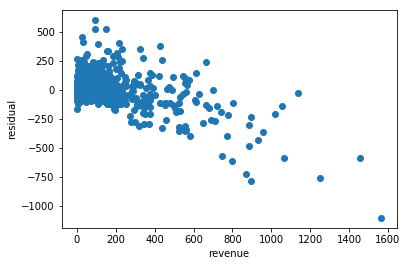

In [80]:
ols_model = linear_model.LinearRegression()
ols_model.fit(x_train,y_train)
evaluate_model(ols_model, x_test,y_test)

Intercept: -235.0027046494504

Coefficients: ['budget: 2.460874899625821', 'runtime: 2.2629817984809084', 'critics_pick: 33.79815246366477', 'is_action: -20.66726109966721', 'is_adventure: 37.94659480996927', 'is_fantasy: 8.665561019718107', 'is_science_fiction: 7.500413177769158', 'is_crime: 4.758299515145648', 'is_drama: -36.69490135852311', 'is_thriller: -6.925210809015678', 'is_animation: 133.67446259075683', 'is_family: 6.132926359266389', 'is_western: -132.26674222442213', 'is_comedy: 3.1480261932897875', 'is_romance: 27.94809039681133', 'is_horror: 42.99764180547365', 'is_mystery: -3.98722231292174', 'is_history: -104.85258121936913', 'is_war: -46.98342593305401', 'is_music: 3.6285463417865738', 'is_documentary: 24.916135150637047', 'rating_g: 27.04200135723259', 'rating_nc_seventeen: 0.0', 'rating_pg: 12.194711519729813', 'rating_pg_thirteen: 10.355126958640247', 'rating_r: -20.38269576685504', 'cast_score: 9.803235254735798', 'director_score: 62.51189649491279']

R-Squared: 0.

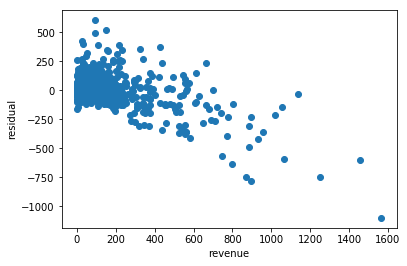

In [74]:
ridge_model = linear_model.Ridge(alpha=0.5)
ridge_model.fit(x_train,y_train)
evaluate_model(ridge_model, x_test,y_test)

Intercept: -230.73698486192998

Coefficients: ['budget: 2.4686951494712104', 'runtime: 2.2465400373714215', 'critics_pick: 33.59873297543513', 'is_action: -20.501410938917072', 'is_adventure: 36.864943931467614', 'is_fantasy: 8.07980356138821', 'is_science_fiction: 6.041596930613616', 'is_crime: 2.7896778842533805', 'is_drama: -37.029574827165185', 'is_thriller: -6.693561150420989', 'is_animation: 133.27217480201244', 'is_family: 6.263764934736927', 'is_western: -125.95054335973451', 'is_comedy: 2.361417412561706', 'is_romance: 27.033867144811904', 'is_horror: 40.01309455943457', 'is_mystery: -2.5058148718725826', 'is_history: -102.52411806139442', 'is_war: -43.74858170417218', 'is_music: 1.325123704596511', 'is_documentary: 18.01684860128271', 'rating_g: 21.643301050249555', 'rating_nc_seventeen: 0.0', 'rating_pg: 10.215047654150567', 'rating_pg_thirteen: 9.139823652319638', 'rating_r: -20.802325102714143', 'cast_score: 9.447420430234372', 'director_score: 59.80893046231349']

R-Squar

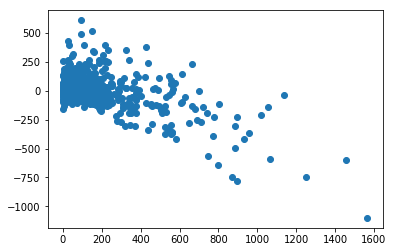

In [63]:
lasso_model = linear_model.Lasso(alpha=0.1,random_state=0)
lasso_model.fit(x_train,y_train)
evaluate_model(lasso_model, x_test,y_test)


Residual Plot


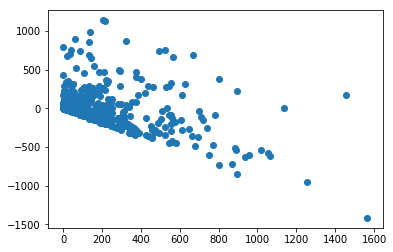

In [70]:
reg_tree_model = DecisionTreeRegressor(random_state=0)
reg_tree_model.fit(x_train,y_train)
evaluate_model(reg_tree_model, x_test,y_test)

0.4746996424538614

Residual Plot


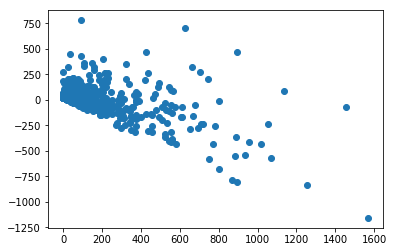

In [71]:
forest_model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
forest_model.fit(x_train,y_train)
print(forest_model.score(x_test,y_test))
evaluate_model(forest_model, x_test,y_test)

## Helper functions
Functions for retrieving data from NYT movies API and OMDB API. Results are saved in csv files.

In [ ]:
#Codes for scraping, dont run. saved to csv file.
NYT_API_KEY = '53223e11b006467490bde835d45b0c74'

all_ny_df = []
for offset in range(0,8000,20):
    url = 'http://api.nytimes.com/svc/movies/v2/reviews/search.json?opening-date=1990-01-01;2016-12-31&offset={0}&api-key=ae71411b586e4f9c82502e7e782b122d'.format(offset)
    ny_json = pd.read_json(url, orient = 'records')
    ny_df = json_normalize(ny_json['results'])
    if ny_df.empty:
        break
    all_ny_df.append(ny_df)

ny_df = pd.concat(all_ny_df)
print(ny_df.tail())
ny_df.to_csv('NY Movie Reviews.csv')


title = 't=' + nytdata['display_title'][1].replace(' ', '+')
req = 'http://www.omdbapi.com/?apikey='+ OMDB_API_KEY + '&'+ title
print(pd.read_json(req))

In [ ]:
OMDB_API_KEY = 'd42886f4'

def fetch_omdb(title):
    title = 't=' + title.replace(' ', '+')
    print (title)
    req = 'http://www.omdbapi.com/?apikey='+ OMDB_API_KEY + '&'+ title
    omdb_df = pd.read_json(req)
    return omdb_df

count = 0
omdb_df_list = []
for title in tmdb_df['title'].tolist():
    count += 1
    omdb_df_list.append(fetch_omdb(title))
    if count > 5:
        break
        
complete = pd.concat(omdb_df_list,axis=0)
complete.to_csv('omdb_data.csv')
